In [2]:
from sklearn.cluster import KMeans
from sklearn.exceptions import UndefinedMetricWarning
import numpy as np
import pandas as pd
import pickle
import os
from scipy.signal import find_peaks, welch
from sklearn.preprocessing import RobustScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

In [3]:
DATA_PATH = '../data/deap-dataset/data_preprocessed_python'
NUM_PARTICIPANTS = 32
RANDOM_STATE = 42
N_CLUSTERS = 4

warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore', category=UndefinedMetricWarning)
warnings.filterwarnings("ignore", category=FutureWarning, module="sklearn")

In [4]:
def load_participant_data(filename):
    """Загрузка данных участника с обработкой ошибок"""
    try:
        with open(filename, 'rb') as f:
            data = pickle.load(f, encoding='latin1')
            assert 'data' in data and 'labels' in data
            return data
    except Exception as e:
        print(f"Ошибка загрузки {filename}: {str(e)}")
        return None

In [5]:
def extract_enhanced_features(data):
    """Извлечение расширенных признаков из одного трейла"""
    features_list = []
    for trial in data:
        eeg = trial[:32]  # 32 канала ЭЭГ

        # Частотные диапазоны
        freq_bands = {
            'delta': (1, 3), 'theta': (4, 7), 'alpha': (8, 13),
            'beta': (14, 30), 'gamma': (31, 45)
        }
        freq_features = []
        for ch in eeg:
            f, psd = welch(ch, fs=128, nperseg=256)
            for band, (low, high) in freq_bands.items():
                band_mask = (f >= low) & (f <= high)
                if np.any(band_mask):
                    band_psd = psd[band_mask]
                    freq_features.extend([
                        np.log1p(np.mean(band_psd)),
                        np.percentile(band_psd, 75),
                        np.std(band_psd)
                    ])

        # Статистические признаки
        stat_features = []
        for ch in eeg:
            ch_norm = (ch - np.mean(ch)) / (np.std(ch) + 1e-6)
            stat_features.extend([
                np.mean(ch),
                np.std(ch),
                np.max(ch) - np.min(ch),
                len(find_peaks(ch_norm, height=1)[0])
            ])

        # ЭКГ (канал 32)
        ecg = trial[32]
        ecg_clean = (ecg - np.median(ecg)) / (np.std(ecg) + 1e-6)
        peaks, _ = find_peaks(ecg_clean, height=1.5, distance=100)
        rr_intervals = np.diff(peaks) / 128.0 if len(peaks) > 1 else np.array([0])
        hrv_features = [
            np.mean(rr_intervals),
            np.std(rr_intervals),
            len(peaks)
        ]

        # GSR (канал 37)
        gsr = trial[37]
        gsr_norm = (gsr - np.min(gsr)) / (np.max(gsr) - np.min(gsr) + 1e-6)
        scr_peaks, _ = find_peaks(gsr_norm, prominence=0.1, distance=50)
        scr_features = [
            np.ptp(gsr),
            np.mean(gsr),
            len(scr_peaks)
        ]

        features_list.append(np.concatenate([
            freq_features,
            stat_features,
            hrv_features,
            scr_features
        ]))
    return np.array(features_list)

In [6]:
def cluster_emotions(labels_df):
    """Кластеризация эмоций с помощью KMeans и интерпретация кластеров"""
    scaler = RobustScaler()
    scaled_labels = scaler.fit_transform(labels_df[['valence', 'arousal', 'dominance']])
    
    kmeans = KMeans(n_clusters=N_CLUSTERS, random_state=RANDOM_STATE)
    clusters = kmeans.fit_predict(scaled_labels)
    
    cluster_stats = labels_df.groupby(clusters)[['valence', 'arousal', 'dominance']].mean()
    
    emotion_map = {}
    for cluster in range(N_CLUSTERS):
        v, a, d = cluster_stats.loc[cluster]
        
        if v > 5 and a > 5:
            emotion_map[cluster] = "excited"
        elif v > 5 and a < 5:
            emotion_map[cluster] = "content"
        elif v < 5 and a > 5:
            emotion_map[cluster] = "angry/fear"
        else:
            emotion_map[cluster] = "neutral"
    
    return [emotion_map[c] for c in clusters], cluster_stats

In [7]:
def build_balanced_pipeline():
    """Создаёт пайплайн с балансировкой и RandomForest"""
    return Pipeline([
        ('scaler', RobustScaler()),
        ('smote', SMOTE(k_neighbors=3, random_state=RANDOM_STATE)),
        ('under', RandomUnderSampler(random_state=RANDOM_STATE)),
        ('model', RandomForestClassifier(
            n_estimators=200,
            max_depth=10,
            random_state=RANDOM_STATE,
            n_jobs=-1
        ))
    ])

In [8]:
def evaluate_model(pipeline, X, y, X_test, y_test):
    """Оценка модели с кросс-валидацией"""
    classes = np.unique(y)
    
    try:
        if len(classes) < 2:
            raise ValueError("Недостаточно классов для классификации")
            
        cv = StratifiedKFold(n_splits=min(5, len(classes)), shuffle=True, random_state=RANDOM_STATE)
        cv_scores = cross_val_score(
            pipeline, X, y, 
            cv=cv, 
            scoring='f1_weighted', 
            n_jobs=-1,
            error_score='raise'
        )
        print(f"CV F1 Score: {np.mean(cv_scores):.3f} ± {np.std(cv_scores):.3f}")
    except Exception as e:
        print(f"Ошибка кросс-валидации: {str(e)}")
        pipeline.fit(X, y)
    else:
        pipeline.fit(X, y)
    
    y_pred = pipeline.predict(X_test)
    
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, zero_division=0))
    
    cm = confusion_matrix(y_test, y_pred, labels=classes)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=classes, yticklabels=classes)
    plt.title('Confusion Matrix')
    plt.show()

In [9]:
def main():
    all_features = []
    all_ratings = []
    
    for i in tqdm(range(1, NUM_PARTICIPANTS + 1), desc="Processing participants"):
        filename = f's{i:02d}.dat'
        filepath = os.path.join(DATA_PATH, filename)

        data = load_participant_data(filepath)
        if data is None:
            continue

        for clip_idx in range(40):
            try:
                labels = data['labels'][clip_idx]
                clip_data = data['data'][clip_idx]
                features = extract_enhanced_features(np.expand_dims(clip_data, axis=0))[0]
                
                all_features.append(features)
                all_ratings.append(labels[:3])
            except Exception as e:
                print(f"Error processing participant {i} clip {clip_idx}: {str(e)}")
                continue

    feature_columns = (
        [f'eeg_{band}_{stat}_ch{ch}'
         for band in ['delta','theta','alpha','beta','gamma']
         for stat in ['log_mean','p75','std']
         for ch in range(32)] +
        [f'eeg_stat_{stat}_ch{ch}'
         for stat in ['mean','std','range','peaks']
         for ch in range(32)] +
        ['hrv_mean', 'hrv_std', 'hr_peaks'] +
        ['gsr_range', 'gsr_mean', 'scr_peaks']
    )
    
    df = pd.DataFrame(all_features, columns=feature_columns)
    ratings_df = pd.DataFrame(all_ratings, columns=['valence', 'arousal', 'dominance'])
    
    emotions, cluster_stats = cluster_emotions(ratings_df)
    df['emotion'] = emotions
    
    print("\nРаспределение кластеров эмоций:")
    print(cluster_stats)
    print("\nРаспределение эмоций:")
    print(df['emotion'].value_counts())
    
    X_train, X_test, y_train, y_test = train_test_split(
        df.drop('emotion', axis=1),
        df['emotion'],
        test_size=0.2,
        stratify=df['emotion'],
        random_state=RANDOM_STATE
    )
    
    pipeline = build_balanced_pipeline()
    evaluate_model(pipeline, X_train, y_train, X_test, y_test)

Processing participants: 100%|██████████| 32/32 [00:26<00:00,  1.19it/s]



Распределение кластеров эмоций:
    valence   arousal  dominance
0  1.664057  2.261543   7.331286
1  3.099868  6.587384   4.360364
2  3.230122  2.822683   3.779207
3  6.192533  3.559067   5.891867

Распределение эмоций:
emotion
neutral       678
angry/fear    302
content       300
Name: count, dtype: int64


/Users/irina/PycharmProjects/pythonProject1/.venv/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/Users/irina/PycharmProjects/pythonProject1/.venv/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/Users/irina/PycharmProjects/pythonProject1/.venv/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer

CV F1 Score: 0.484 ± 0.009

Classification Report:
              precision    recall  f1-score   support

  angry/fear       0.40      0.50      0.44        60
     content       0.31      0.30      0.30        60
     neutral       0.58      0.52      0.55       136

    accuracy                           0.46       256
   macro avg       0.43      0.44      0.43       256
weighted avg       0.47      0.46      0.47       256



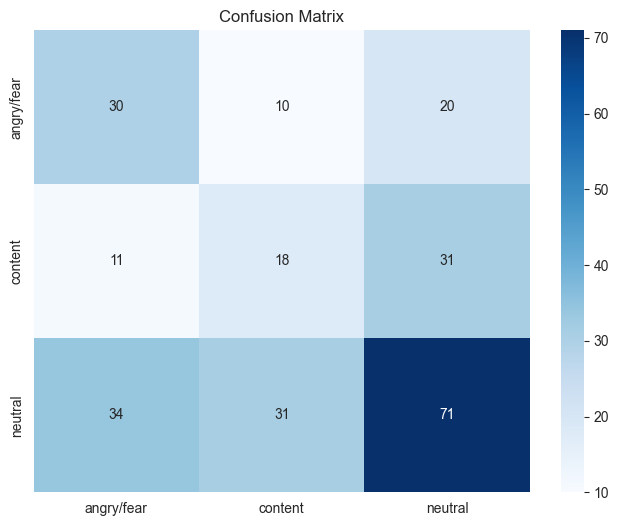

In [10]:
if __name__ == "__main__":
    main()